# Lattice computations

In [1]:
import openmc
from IPython.display import Image

In this section, we will build one of the assemblies from the BEAVRS benchmark.  This is a PWR assembly with fuel pins, guide tubes, and borosilicate glass burnable poisons.  A diagram of th assembly is plotted below.  To make it a little easier (and improve our statistics!) we will only build one quarter of it.

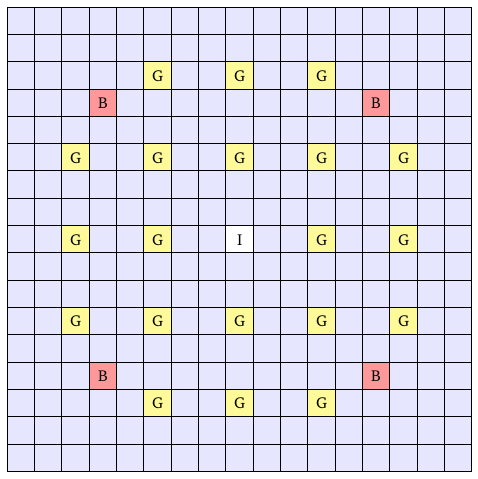

In [2]:
Image('assembly_diagram.png')

## Materials

We have the same UO2, Zr, and H2O from the pincell example.  We also have borosilicate glass (pyrex).  Note the shortcut of calling `add_nuclide` and `add_element` without initializing a nuclide/element.

In [3]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.02115, 'wo')
uo2.add_nuclide('U238', 0.86032, 'wo')
uo2.add_nuclide('O16', 0.11852, 'wo')
uo2.set_density('g/cm3', 10.3)

zirconium = openmc.Material(name='zirconium')
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.55)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2)
water.add_nuclide('O16', 1)
water.set_density('g/cm3', 0.701)
water.add_s_alpha_beta('c_H_in_H2O')

pyrex = openmc.Material(name='pyrex')
pyrex.add_element('B', 4.88396e-3)
pyrex.add_element('O', 4.6624e-2)
pyrex.add_element('Al', 1.7352e-3)
pyrex.add_element('Si', 1.83512e-2)
pyrex.set_density('g/cm3', 2.26)

In [4]:
mf = openmc.Materials((uo2, zirconium, water, pyrex))
mf.export_to_xml()

Later in this example, we will make a bunch of geometry plots.  By default, every region is colored randomly and the results are Now that we know our materials, let's define a "color specification" to use when plotting our geometry.

In [5]:
col_spec = {}
col_spec[water.id] = (100, 200, 200)
col_spec[zirconium.id] = (150, 150, 150)
col_spec[pyrex.id] = (100, 255, 100)
col_spec[uo2.id] = (255, 50, 50)

## Fuel pin

This is similar to the pincell example, but we don't have boundary conditions.  This `fuel_pin` universe extends to infinity

In [6]:
pitch = 1.25984

fuel_or = openmc.ZCylinder(R=0.39218)
clad_ir = openmc.ZCylinder(R=0.40005)
clad_or = openmc.ZCylinder(R=0.45720)

fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = -fuel_or

gap = openmc.Cell(2, 'air gap')
gap.fill = 'void'
gap.region = +fuel_or & -clad_ir

clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = +clad_ir & -clad_or

moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = +clad_or

fuel_pin = openmc.Universe()
fuel_pin.add_cells((fuel, gap, clad, moderator))

When building a complex geometry, it is helpful to plot each universe as you go along.  Let's plot this pincell now

In [7]:
# We need a cell to contain the fuel_pin universe.
main = openmc.Cell()
main.fill = fuel_pin

root = openmc.Universe(0)
root.add_cell(main)

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()

In [8]:
p = openmc.Plot()
p.width = [pitch, pitch]
p.pixels = [400, 400]
p.color = 'mat'
p.col_spec = col_spec

plots = openmc.Plots([p])
plots.export_to_xml()

In [9]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

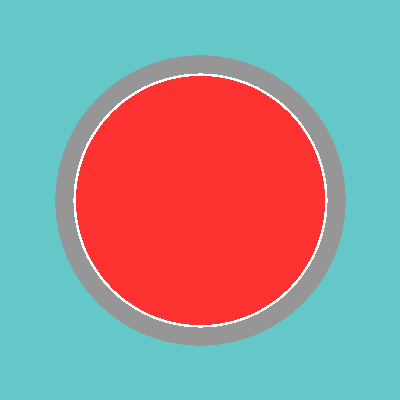

In [10]:
!convert plot.ppm plot.png
Image("plot.png")

## Guide tube

In [11]:
clad_ir = openmc.ZCylinder(R=0.56134)
clad_or = openmc.ZCylinder(R=0.60198)

inner = openmc.Cell()
inner.fill = water
inner.region = -clad_ir

clad = openmc.Cell()
clad.fill = zirconium
clad.region = +clad_ir & -clad_or

outer = openmc.Cell()
outer.fill = water
outer.region = +clad_or

guide_tube = openmc.Universe()
guide_tube.add_cells((inner, clad, outer))

In [12]:
main = openmc.Cell()
main.fill = guide_tube

root = openmc.Universe(0)
root.add_cell(main)

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()

In [13]:
p = openmc.Plot()
p.width = [pitch, pitch]
p.pixels = [400, 400]
p.color = 'mat'
p.col_spec = col_spec

plots = openmc.Plots([p])
plots.export_to_xml()

In [14]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

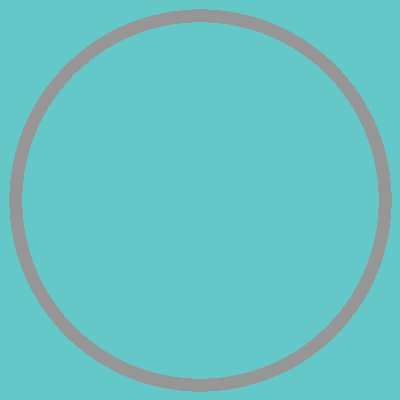

In [15]:
!convert plot.ppm plot.png
Image("plot.png")

## Pyrex burnable poison

In [16]:
# Define the cylinders which bound each radial zone.
radii = [0.21400, 0.23051, 0.24130, 0.42672, 0.43688, 0.48387, 0.56134, 0.60198]
cyls = [openmc.ZCylinder(R=R) for R in radii]

# Initialize a list of cells.
bp_cells = []

# Define the inner void zone first.
c = openmc.Cell()
c.region = -cyls[0]
c.fill = 'void'
bp_cells.append(c)

# Now all the sandwiched layers.
mats = [zirconium, 'void', pyrex, 'void', zirconium, water, zirconium]
for i in range(len(mats)):
    c = openmc.Cell()
    c.region = +cyls[i] & -cyls[i+1]
    c.fill = mats[i]
    bp_cells.append(c)

# And the outer moderator region.
c = openmc.Cell()
c.region = +cyls[-1]
c.fill = water
bp_cells.append(c)

# Make a universe containing these cells
burn = openmc.Universe()
burn.add_cells(bp_cells)

In [17]:
main = openmc.Cell()
main.fill = burn

root = openmc.Universe(0)
root.add_cell(main)

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()

In [18]:
p = openmc.Plot()
p.width = [pitch, pitch]
p.pixels = [400, 400]
p.color = 'mat'
p.col_spec = col_spec

plots = openmc.Plots([p])
plots.export_to_xml()

In [19]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

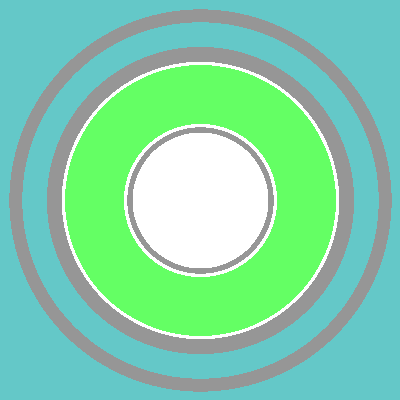

In [20]:
!convert plot.ppm plot.png
Image("plot.png")

## Lattices in OpenMC

OpenMC has `RectLattice` and `HexLattice` objects.  This demo will use a `RectLattice`.  Let's look at a simple one before we do the quarter assembly.

First, we also need to define a universe that is all water.

In [21]:
moderator = openmc.Cell()
moderator.fill = water

all_water = openmc.Universe()
all_water.add_cell(moderator)

In [22]:
lattice = openmc.RectLattice()

# First we specify the dimension---the number of lattice tiles in x and y.
lattice.dimension = [2, 2]

# Next is the lower-left corner of the lattice.
lattice.lower_left = [0.0, 0.0]

# Next is the pitch---the size of the lattice tiles in each direction.
lattice.pitch = [pitch]*2

# Now we specify what is actually inside the lattice.  This 2D lattice will be a
# list of lists like
# lattice.universes = [ [a1, a2, ...], [b1, b2, ...], ...]
# The inner lists specify columns from left to right.  The outer lists specify
# rows from top to bottom.
lattice.universes = [
    [fuel_pin,   fuel_pin],
    [guide_tube, fuel_pin]
]

# We also need to specify what is outside of the lattice.  In this case, it is
# the infinite water universe.
lattice.outer = all_water

In [23]:
main = openmc.Cell()
main.fill = lattice

root = openmc.Universe(0)
root.add_cell(main)

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()

In [24]:
p = openmc.Plot()
p.origin = (pitch, pitch, 0)
p.width = (3*pitch, 3*pitch)
p.pixels = (400, 400)
p.color = 'mat'

col_spec = {}
col_spec[water.id] = (100, 200, 200)
col_spec[zirconium.id] = (150, 150, 150)
col_spec[pyrex.id] = (100, 255, 100)
col_spec[uo2.id] = (255, 50, 50)
p.col_spec = col_spec

plots = openmc.Plots([p])
plots.export_to_xml()

In [25]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

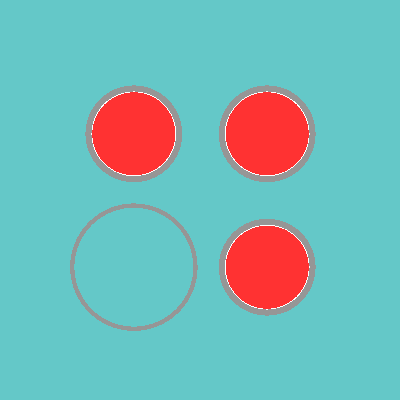

In [26]:
!convert plot.ppm plot.png
Image("plot.png")

## What exactly does `outer` mean?

We are taking that one universe and tiling it infinitely outside the lattice.

In [27]:
# Try a different outer universe to see what I mean
lattice.outer = guide_tube

g.export_to_xml()

openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

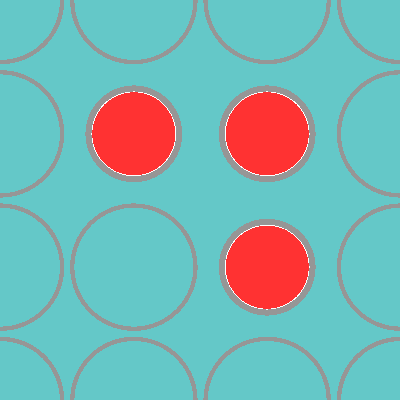

In [28]:
!convert plot.ppm plot.png
Image("plot.png")

## The BEAVRS assembly

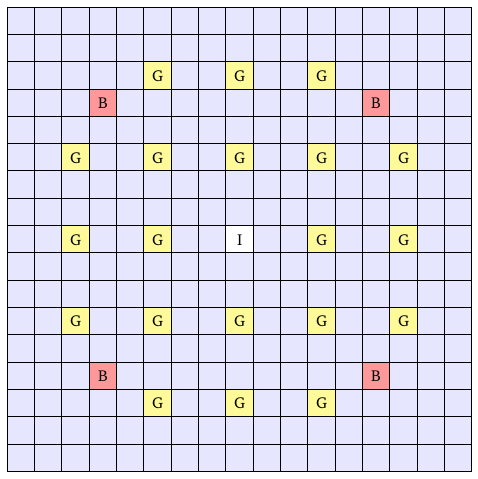

In [29]:
Image('assembly_diagram.png')

In [30]:
lattice = openmc.RectLattice()

lattice.dimension = [9, 9]
lattice.pitch = [pitch]*2
lattice.outer = all_water

# I want (x0, y0) = (0, 0) to be the center of the instrument tube so that means
# the lower-left will be -half a pin pitch in x and y.
lattice.lower_left = [-pitch/2.0]*2

# Most of the lattice positions are fuel pins so rather than type all of those
# out, I will use a Python list comprehension to start with a 9x9 array of fuel.
lattice.universes = [[fuel_pin for i in range(9)] for j in range(9)]

# Then I will replace some fuel pins with guide tubes.  First index is the row,
# starting from the top, and the second is the column (like a matrix).
lattice.universes[2][0] = guide_tube
lattice.universes[2][3] = guide_tube
lattice.universes[5][0] = guide_tube
lattice.universes[5][3] = guide_tube
lattice.universes[5][6] = guide_tube
lattice.universes[8][0] = guide_tube
lattice.universes[8][3] = guide_tube
lattice.universes[8][6] = guide_tube

# And the burnable poison rod.
lattice.universes[3][5] = burn

Now we just have to add the boundary conditions and root universe to finish the geometry.

In [31]:
height = 100 # Finite height makes me feel better
assembly_pitch = 21.50364
x0 = openmc.XPlane(x0=0.0, boundary_type='reflective')
x1 = openmc.XPlane(x0=assembly_pitch/2.0, boundary_type='reflective')
y0 = openmc.YPlane(y0=0.0, boundary_type='reflective')
y1 = openmc.YPlane(y0=assembly_pitch/2.0, boundary_type='reflective')
z0 = openmc.ZPlane(z0=-height/2.0, boundary_type='reflective')
z1 = openmc.ZPlane(z0=height/2.0, boundary_type='reflective')

main = openmc.Cell()
main.region = +x0 & -x1 & +y0 & -y1 & +z0 & -z1
main.fill = lattice

In [32]:
root = openmc.Universe(0)
root.add_cell(main)

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()

In [33]:
p = openmc.Plot()
p.origin = (0.25*assembly_pitch, 0.25*assembly_pitch, 0)
p.width = (0.55*assembly_pitch, 0.55*assembly_pitch)
p.pixels = (700, 700)
p.color = 'mat'

p.col_spec = col_spec

plots = openmc.Plots([p])
plots.export_to_xml()

In [34]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

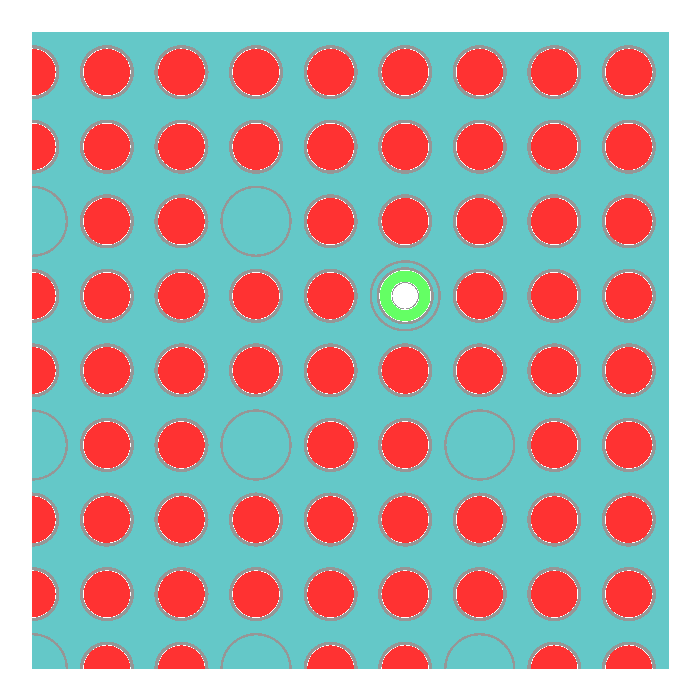

In [35]:
!convert plot.ppm plot.png
Image("plot.png")

In [36]:
settings = openmc.Settings()
settings.source = openmc.Source(space=openmc.stats.Box((0.1, 0.1, 0), (0.49*assembly_pitch, 0.49*assembly_pitch, 0)))
settings.batches = 50
settings.inactive = 10
settings.particles = 1000
settings.export_to_xml()

In [37]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tallies

Okay, that was cool, but $k_\text{eff}$ isn't everyting.  We also want to know reaction rates so we can compute the power distribution, depletion rate, etc.  If we want pin-by-pin reaction rates, we have two options.  First, we can use a tally mesh.  This will lay a rectangular grid over the geometry and tally the reaction rates in each mesh bin.

In [38]:
tallies = openmc.Tallies()

mesh = openmc.Mesh()
mesh.dimension = lattice.dimension
#mesh.dimension = [3, 3] # Only show a few cells for this example
mesh.lower_left = lattice.lower_left
mesh.width = lattice.pitch

mesh_filt = openmc.MeshFilter(mesh)

t = openmc.Tally(1)
t.filters = [mesh_filt]
t.scores = ['total', 'fission']
t.nuclides = ['total', 'U235']
tallies.append(t)

Or we can use something called a "distribcell" filter.  Note that the bin specifies a cell id.

In [39]:
dist_filt = openmc.DistribcellFilter(fuel.id)
t = openmc.Tally(2)
t.filters = [dist_filt]
t.scores = ['total', 'fission']
t.nuclides = ['total', 'U235']
tallies.append(t)

tallies.export_to_xml()

In [40]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [41]:
!cat tallies.out


 ============================>     TALLY 1     <============================

 Mesh Index (1, 1)
   Total Material
     Total Reaction Rate                  0.142318       +/- 3.88721E-03
     Fission Rate                         0.0            +/- 0.0
   U235
     Total Reaction Rate                  0.0            +/- 0.0
     Fission Rate                         0.0            +/- 0.0
 Mesh Index (2, 1)
   Total Material
     Total Reaction Rate                  0.224721       +/- 5.05550E-03
     Fission Rate                         4.14976E-03    +/- 2.03861E-04
   U235
     Total Reaction Rate                  5.28334E-03    +/- 2.50044E-04
     Fission Rate                         3.93047E-03    +/- 2.03192E-04
 Mesh Index (3, 1)
   Total Material
     Total Reaction Rate                  0.237917       +/- 4.32879E-03
     Fission Rate                         4.71455E-03    +/- 2.02158E-04
   U235
     Total Reaction Rate                  5.95924E-03    +/- 2.42952E-04
     Fi

## Distributed materials

In a depletion problem, every fuel pin might need its own unique material.  We have a feature called "distributed materials" which makes this easier.

In [42]:
many_uo2_mats = []
for i in range(72):
    m = openmc.Material(name='uo2')
    m.add_nuclide('U235', 0.02115, 'wo')
    m.add_nuclide('U238', 0.86032, 'wo')
    m.add_nuclide('O16', 0.11852, 'wo')
    m.set_density('g/cm3', 10.3)
    many_uo2_mats.append(m)

mf.add_materials(many_uo2_mats)
mf.export_to_xml()

In [43]:
fuel.fill = many_uo2_mats
g.export_to_xml()

In [44]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

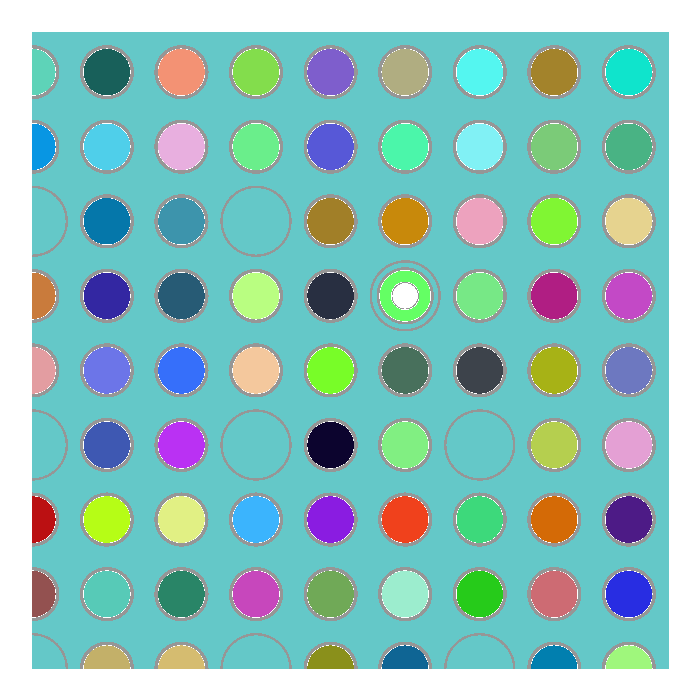

In [45]:
!convert plot.ppm plot.png
Image("plot.png")